In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import numpy as np

import os
import sys
sys.path.append('../')

In [2]:
from src.img_processing import ImageProcessor
from src.model import CPPN
from src.audio_processing import AudioProcessor

In [3]:
videopath = '../test.mp4'
audiopath = '../audio/TRAPPIST.wav'

In [4]:
img_processor = ImageProcessor('../references/test.png')

In [5]:
audio_processor = AudioProcessor(audiopath)

In [6]:
amps = audio_processor.get_amplitudes(False)
amps.shape

(4698, 8)

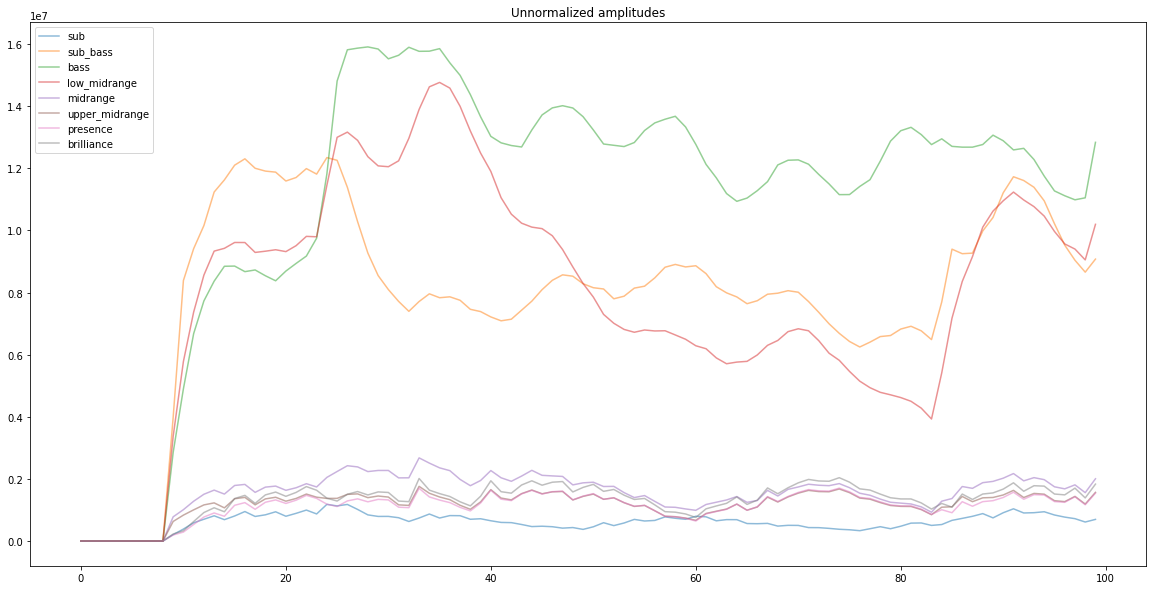

In [7]:
amps_names = 'sub sub_bass bass low_midrange midrange upper_midrange presence brilliance'.split()

plt.figure(figsize=(20,10))
plt.plot(amps[:100], alpha=0.5, label=amps_names)
plt.legend()
plt.title('Unnormalized amplitudes')
plt.show()

In [8]:
amps = audio_processor.get_amplitudes(True) # normalized amplitudes

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
model = CPPN(inp_dim=5, n_layers=6)
model.load_state_dict(torch.load('../models/test_model.pt'))
if device.type == 'cuda':
    model.cuda()

model.eval()

CPPN(
  (input_layer): Linear(in_features=5, out_features=32, bias=True)
  (layer): Linear(in_features=32, out_features=32, bias=True)
  (out_layer): Linear(in_features=32, out_features=3, bias=True)
)

In [11]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.normal_(m.weight)
#         m.bias.data.fill_(0.01)

In [12]:
# model = CPPN(inp_dim=5, n_layers=6)
# if device.type == 'cuda':
#     model.cuda()

# model.apply(init_weights)
# model.eval()

In [13]:
for t in tqdm(range(len(amps))):
    
    features = amps[t]
    cost = np.cos(2 * np.pi * t / (64 * 30))
    
    grid = img_processor.generate_custom_grid(features, cost)
    grid = torch.tensor(grid)
    if device.type == 'cuda':
        grid = grid.to(device)
        output = model(grid).cpu().detach().numpy()
    else:
        output = model(grid).detach().numpy()
    
    out_img = img_processor.get_img_from_arr(output)
    
    cv2.imwrite('../frames/%06d.png' % t, out_img)

  0%|          | 0/4698 [00:00<?, ?it/s]

In [14]:
os.system('ffmpeg -r 30 -i ../frames/%06d.png -i ' + audiopath + ' -crf 25 -vcodec mpeg4 -y ' + videopath)

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

0

In [16]:
os.system('ffmpeg -ss 60 -t 10 -i ../test.mp4 -vf "fps=30,scale=300:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 ../test.gif')

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

0